In [175]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.stats import ortho_group
import scipy

In [176]:
data = pd.read_csv("/Users/lucastucker/REU-2023/archive/mnist_train.csv")
data = np.array(data)
np.random.shuffle(data)

In [177]:
data.shape

(60000, 785)

In [178]:
m = 2000 # number of MNIST images sampled
n = 784 # number of pixels per MNIST image
t = 10 # number of neighbors measured
sample = data[:m]
X = sample[:, 1:].T / 255
X.shape

(784, 2000)

In [179]:
def get_random_projection(k, X):
    R = np.random.normal(size = (n, k)) 
    frob_norm = np.linalg.norm(R.dot(R.T).dot(X) - X)
    print(f"frobenius norm for random projection is {frob_norm}")
    return R.T.dot(X)

In [180]:
def get_pca(k, X):
    mean_centered_data = X - np.mean(X, axis=1, keepdims=True)
    covariance_matrix = np.cov(mean_centered_data) 
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    proj = sorted_eigenvectors[:, :k] # top k minimize the frobenius norm
    frob_norm = np.linalg.norm(proj.dot(proj.T).dot(X) - X)
    print(f"frobenius norm for normal pca is {frob_norm}")
    reduced_data = np.dot(proj.T, mean_centered_data)
    return reduced_data

In [181]:
# This is performed according to the gradient calculated in the paper
def gradient_pca(k, X, tolerance, step):

    X = X - np.mean(X, axis=1, keepdims=True)
    diff = math.inf
    proj = ortho_group.rvs(dim=n)[:, :k] # random n x k orthogonal matrix
    norm = np.linalg.norm(proj)
    proj = proj / norm
    frob_norm = math.inf
    
    num_iterations = 20

    while diff > tolerance and num_iterations > 0:
        DF = 2 * proj.dot(proj.T).dot(X).dot(X.T).dot(proj) - \
        4 * X.dot(X.T).dot(proj) + 2 * X.dot(X.T).dot(proj).dot(proj.T).dot(proj)

        DF = DF / np.linalg.norm(DF) # Keep the gradient matrix normalized

        proj_new = (proj - step * DF) # gradient descent step
        diff = np.linalg.norm(proj - proj_new)
        proj = proj_new
        num_iterations -= 1

    U, s, Vh = scipy.linalg.svd(proj, full_matrices=False)
    output = U.dot(Vh)

    frob_norm = np.linalg.norm(output.dot(output.T).dot(X) - X)
    print(f"frobenius norm for gradient descent pca is {frob_norm}") # the objective function

    return output.T.dot(X)

In [182]:
def nearest_t_nbrs(t, X):
    t_nearest = np.ones((m, t), dtype=int) * 1
    for id, row in enumerate(X.T):
        dif = X.T - row # get vector representation-wise differences
        norm_indices = np.argsort(np.linalg.norm(dif, axis = 1))
        t_nearest[id] = norm_indices[1: t + 1]
    return t_nearest # returns m x t matrix representing k_nearest

In [183]:
def t_similarity_score(t, X, X_reduced):
    pixelwise_t_nearest = nearest_t_nbrs(t, X)
    reduced_t_nearest = nearest_t_nbrs(t, X_reduced)
    shared_elems_list = []
    for row, row_tilde in zip(pixelwise_t_nearest, reduced_t_nearest):
        set_1 = set(row)
        set_2 = set(row_tilde)
        shared_elem_count = len(set_1.intersection(set_2))
        shared_elems_list.append(shared_elem_count)
    shared_elems = np.array(shared_elems_list) # row-wise intersection counts
    avg_shared = (1/m) * np.sum(shared_elems)
    return (avg_shared / t)

In [184]:
k = 100 # Size of reduced dimension

In [185]:
def normal_pca_similarity_score(k):
    X_pca = get_pca(k, X)
    return t_similarity_score(t, X, X_pca)

In [186]:
def random_similarity_score(k):
    X_random = get_random_projection(k, X)
    return t_similarity_score(t, X, X_random)

In [187]:
def gradient_pca_similarity_score(k, tol = 0.001, step = 1):
    X_gradient_pca = gradient_pca(k, X, tol, step)
    return t_similarity_score(t, X, X_gradient_pca)

<class 'int'>
k_vals are 100
frobenius norm for normal pca is 91.78863721018176
frobenius norm for random projection is 127198.523499952
proj shape is (784, 100)
output shape is (784, 100)
frobenius norm for gradient descent pca is 130.05804855571694


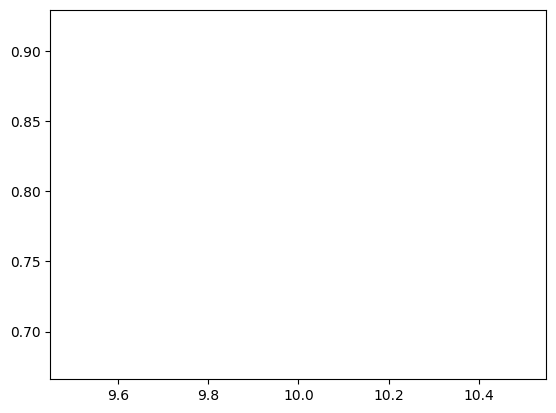

In [196]:
# k_vals = np.logspace(1, 9, num = 10, base = 2) #.astype(int)
k_vals = 100
print(type(k_vals))
print(f"k_vals are {k_vals}")
a = normal_pca_similarity_score(k_vals)
b = random_similarity_score(k_vals)
c = gradient_pca_similarity_score(k_vals)

plt.plot(t, a, 'r') # plotting t, a separately 
plt.plot(t, b, 'b') # plotting t, b separately 
plt.plot(t, c, 'g') # plotting t, c separately 
plt.show()